In [1]:
#Fastai imports --> they include a lot of the things we need
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/Users/ting2liu/fastai/')
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [46]:
#Read loans.csv
data = pd.read_csv('~/data/kiva/kiva_ds_csv/loans.csv',
                   parse_dates=["posted_time", "planned_expiration_time",
                               "disbursed_time", "funded_time"])

In [47]:
#Define function to get a better glimpse on all the columns of the data
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [48]:
#Dimensions of raw data
raw_dims = data.shape
raw_dims

(1312838, 34)

In [30]:
#Get a first taste of what the raw data looks like
display_all(data.tail().transpose())

,1312833,1312834,1312835,1312836,1312837
id,1162887,1163770,1164070,1256190,1179035
name,AGATHA,Emily,Wilma,Jason,Frank
original_language,English,English,English,English,English
original_description,Agatha is a married woman with 2 children. She...,"Emily is 44 years old, married and has three c...",Wilma is a married woman with five children. S...,I grew up in a 9 sibling household in the west...,I'm 100% Native American. I was born and raise...
translated_description,Agatha is a married woman with 2 children. She...,"Emily is 44 years old, married and has three c...",Wilma is a married woman with five children. S...,I grew up in a 9 sibling household in the west...,I'm 100% Native American. I was born and raise...
funded_amount,300,275,175,0,0
loan_amount,300,275,175,3000,1000
status,funded,funded,funded,expired,expired
image_id,2.32755e+06,2.32903e+06,2.32972e+06,2.4687e+06,2.35164e+06
video_id,NaN,NaN,NaN,NaN,NaN


In [31]:
#Display the percentage of missing values for each column in the raw data
display_all(data.isnull().sum().sort_index()/len(data))

activity                           0.000000
borrower_genders                   0.022281
borrower_names                     0.025585
borrower_pictured                  0.022281
bulk_journal_entries_count         0.000000
country_code                       0.000007
country_name                       0.000000
currency                           0.000000
currency_exchange_coverage_rate    0.240176
currency_policy                    0.000000
disbursed_time                     0.001865
distribution_model                 0.000000
funded_amount                      0.000000
funded_time                        0.045974
id                                 0.000000
image_id                           0.022281
journal_entries_count              0.000000
lender_count                       0.000000
loan_amount                        0.000000
name                               0.025585
original_description               0.022303
original_language                  0.022281
partner_id                      

## `add_datepart` to `posted_time`

  `add_datepart` converts a column of df from a datetime64 to many columns containing the information from the date. 

  Note: The original 'posted_time' column is kept too just in case we still need the original column!

In [49]:
add_datepart(data, 'posted_time', drop=False)

In [50]:
data.shape

(1312838, 47)

In [34]:
display_all(data.tail().transpose())

,1312833,1312834,1312835,1312836,1312837
id,1162887,1163770,1164070,1256190,1179035
name,AGATHA,Emily,Wilma,Jason,Frank
original_language,English,English,English,English,English
original_description,Agatha is a married woman with 2 children. She...,"Emily is 44 years old, married and has three c...",Wilma is a married woman with five children. S...,I grew up in a 9 sibling household in the west...,I'm 100% Native American. I was born and raise...
translated_description,Agatha is a married woman with 2 children. She...,"Emily is 44 years old, married and has three c...",Wilma is a married woman with five children. S...,I grew up in a 9 sibling household in the west...,I'm 100% Native American. I was born and raise...
funded_amount,300,275,175,0,0
loan_amount,300,275,175,3000,1000
status,funded,funded,funded,expired,expired
image_id,2.32755e+06,2.32903e+06,2.32972e+06,2.4687e+06,2.35164e+06
video_id,NaN,NaN,NaN,NaN,NaN


## Add Columns:

`time_to_funding` = funded_time - posted_time

`max_time_to_funding` = planned_expiration_time - posted_time

`hours_to_funding` = time_to_funding as Hours

`max_hours_to_funding` = max_time_to_funding as Hours

`prop_hr_to_funding` = hours_to_funding / loan_amount

In [51]:
#Add new columns
data['time_to_funding'] = data.funded_time - data.posted_time
data['max_time_to_funding'] = data.planned_expiration_time - data.posted_time

In [52]:
#Convert added columns to hours (add two more columns)
data['hours_to_funding'] = data.time_to_funding.astype('timedelta64[h]')
data['max_hours_to_funding'] = data.max_time_to_funding.astype('timedelta64[h]')

In [53]:
data['prop_hr_to_funding'] = data.hours_to_funding / data.loan_amount

In [54]:
raw2_dims = data.shape
raw2_dims

(1312838, 52)

## Start from January 2007, and only loans that took 90 days or less to fund!

In [55]:
#Exclude loans posted before 2007 and those that took more than 90 days to fund (except NaNs)
data = data.query('posted_time>=2007 and (hours_to_funding<2161 or hours_to_funding != hours_to_funding)') #90 days = 2160 hours
data[['posted_time','hours_to_funding', 'status']].head(40)

,posted_time,hours_to_funding,status
0,2012-08-28 21:49:16,711.0,funded
1,2012-08-31 20:29:03,301.0,funded
2,2012-09-04 12:29:55,153.0,funded
3,2012-09-04 15:15:59,NaN,expired
4,2012-09-06 11:05:56,281.0,funded
5,2012-09-07 19:26:15,485.0,funded
6,2012-09-10 12:03:49,NaN,expired
7,2012-09-17 10:33:24,198.0,funded
8,2012-08-30 06:50:41,115.0,funded
9,2012-09-06 07:03:15,595.0,funded


In [56]:
adjusted_dims = data.shape
adjusted_dims

(1307527, 52)

#### Removed loans that were posted before 2007 and those that took more than 90 days to fund

In [58]:
#Rows deleted (absolute and proportion)
print(raw_dims[0] - adjusted_dims[0])
print((raw_dims[0] - adjusted_dims[0])/raw_dims[0])

5311
0.004045434394799663


## Remove rows with 'refunded' or 'fundRaising' status!

In [59]:
#Get rid of rows with status = 'refunded' or status = 'fundRaising'
data = data.query("status!='refunded' and status!='fundRaising'")

In [60]:
adjusted2_dims = data.shape
adjusted2_dims

(1296140, 52)

#### Removed loans that have 'refunded' or 'fundRaising' status

In [61]:
#Rows deleted (absolute and proportion) FROM RAW data
print(raw_dims[0] - adjusted2_dims[0])
print((raw_dims[0] - adjusted2_dims[0])/raw_dims[0])

16698
0.012719010266308561


In [62]:
#Rows deleted (absolute and proportion) AFTER first removal
print(adjusted_dims[0] - adjusted2_dims[0])
print((adjusted_dims[0] - adjusted2_dims[0])/adjusted_dims[0])

11387
0.008708806777986229


## Remove rows with negative funding_time!

In [63]:
data[data.prop_hr_to_funding<0]

,id,name,original_language,original_description,translated_description,funded_amount,loan_amount,status,image_id,video_id,...,posted_timeIs_quarter_end,posted_timeIs_quarter_start,posted_timeIs_year_end,posted_timeIs_year_start,posted_timeElapsed,time_to_funding,max_time_to_funding,hours_to_funding,max_hours_to_funding,prop_hr_to_funding
879445,1281091,Hortenisa,English,My name is Hortensia and I came to Oakland 29 ...,My name is Hortensia and I came to Oakland 29 ...,2000.0,2000.0,funded,2502198.0,NaN,...,False,False,False,False,1494806400,-18 days +11:52:24,10 days 19:36:39,-421.0,259.0,-0.2105


In [64]:
data.shape

(1296140, 52)

In [65]:
#Eliminate negative funding_time row(s)
data = data.query('prop_hr_to_funding>=0 or prop_hr_to_funding!=prop_hr_to_funding')

In [66]:
data.shape

(1296139, 52)

# Missing Descriptions Analysis

In [67]:
data[['original_language', 'original_description', 'translated_description']]

,original_language,original_description,translated_description
0,Spanish,"Norma tiene 38 años de edad, es madre soltera ...",Norma is 38 years old. She is a single mother ...
1,Spanish,sayda es originaria de la comarca Empalme de B...,Sayda is originally from the Empalme de Boaco ...
2,English,Livia is 38 years old and is married to David ...,NaN
3,Spanish,El señor Eduardo de 37 años de edad casado con...,Eduardo is 37 years old. He has been to marrie...
4,English,"Nhanh, age 49, lives in a rural area in the Po...",NaN
5,Spanish,"Rosa, de 42 años, es una mujer amable, solidar...","Rosa, 42 years old, is a nice woman, companion..."
6,English,"Artur lives in Vedi town, Ararat region, with ...",NaN
7,English,Nada is a 45-year-old married woman and mother...,NaN
8,English,"Ines is a 55-year-old woman from Talibon, Boho...",NaN
9,English,Mahmoud is a 44- year-old married man and a fa...,NaN


In [69]:
#how many descriptions are missing
len(data[data.original_description != data.original_description])

22513

In [70]:
no_desc = data[data.original_description != data.original_description]

In [71]:
len(no_desc)

22513

In [75]:
display_all(no_desc.tail().transpose())

,1311734,1311869,1311924,1311949,1311996
id,128685,122099,139098,122585,135273
name,NaN,NaN,NaN,NaN,NaN
original_language,NaN,NaN,NaN,NaN,NaN
original_description,NaN,NaN,NaN,NaN,NaN
translated_description,NaN,NaN,NaN,NaN,NaN
funded_amount,975,1150,150,1075,1100
loan_amount,975,1150,150,1075,1100
status,funded,funded,funded,funded,funded
image_id,NaN,NaN,NaN,NaN,NaN
video_id,NaN,NaN,NaN,NaN,NaN


In [79]:
type(no_desc['posted_time'])

pandas.core.series.Series

In [80]:
no_desc['posted_time2'] = pd.to_datetime(no_desc['posted_time'])

/Users/ting2liu/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
no_desc.shape

(22513, 53)

In [88]:
no_desc.describe(include='all')

,id,name,original_language,original_description,translated_description,funded_amount,loan_amount,status,image_id,video_id,...,posted_timeIs_quarter_start,posted_timeIs_year_end,posted_timeIs_year_start,posted_timeElapsed,time_to_funding,max_time_to_funding,hours_to_funding,max_hours_to_funding,prop_hr_to_funding,posted_time2
count,2.251300e+04,29,29,0.0,0.0,22513.000000,22513.000000,22513,2.900000e+01,0.0,...,22513,22513,22513,2.251300e+04,22507,12360,22507.000000,12360.000000,22507.000000,22513
unique,NaN,24,1,0.0,0.0,NaN,NaN,2,NaN,NaN,...,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,22512
top,NaN,Nguyễn,English,NaN,NaN,NaN,NaN,funded,NaN,NaN,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-04 00:44:59
freq,NaN,3,29,NaN,NaN,NaN,NaN,22507,NaN,NaN,...,22375,22499,22509,NaN,NaN,NaN,NaN,NaN,NaN,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-03 06:47:15
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-25 03:45:56
mean,3.883976e+05,NaN,NaN,NaN,NaN,857.357971,858.080887,NaN,8.291610e+05,NaN,...,NaN,NaN,NaN,1.317251e+09,10 days 17:01:56.531079,38 days 02:51:17.110517,256.532190,914.354854,0.456987,NaN
std,2.356510e+05,NaN,NaN,NaN,NaN,1071.801672,1074.886473,NaN,7.105978e+05,NaN,...,NaN,NaN,NaN,6.873324e+07,11 days 09:28:18.313551,10 days 12:32:10.959820,273.471809,252.534852,0.578127,NaN
min,3.379000e+03,NaN,NaN,NaN,NaN,0.000000,25.000000,NaN,3.064920e+05,NaN,...,NaN,NaN,NaN,1.167807e+09,0 days 00:07:36,16 days 03:48:11,0.000000,387.000000,0.000000,NaN
25%,1.873360e+05,NaN,NaN,NaN,NaN,350.000000,350.000000,NaN,3.363110e+05,NaN,...,NaN,NaN,NaN,1.269273e+09,2 days 11:02:04.500000,31 days 09:42:33.250000,59.000000,753.000000,0.091429,NaN


In [91]:
pd.DataFrame.describe(no_desc[['posted_time2']])

,posted_time2
count,22513
unique,22512
top,2007-12-04 00:44:59
freq,2
first,2007-01-03 06:47:15
last,2016-08-25 03:45:56


In [104]:
no_desc['posted_timeMonth'].dtype

category

In [95]:
no_desc['posted_timeMonth'] = no_desc['posted_timeMonth'].astype('category')

/Users/ting2liu/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
pd.DataFrame.describe(no_desc[['posted_timeMonth']])

,posted_timeMonth
count,22513
unique,12
top,11
freq,2654


In [102]:
no_desc['posted_timeMonth'].value_counts()

11    2654
12    2395
10    2109
3     1910
9     1841
8     1784
7     1734
5     1645
6     1642
4     1636
2     1605
1     1558
Name: posted_timeMonth, dtype: int64

In [106]:
data['posted_timeMonth'].value_counts()

3     121616
5     117247
6     114629
11    112378
4     109319
10    108739
2     106989
12    105004
9     102865
7     100901
8      98521
1      97931
Name: posted_timeMonth, dtype: int64

In [112]:
no_desc['posted_timeYear'].value_counts()/len(no_desc['posted_timeYear'])

2012    0.240350
2013    0.194510
2010    0.131169
2011    0.098654
2007    0.098210
2014    0.090259
2009    0.074846
2008    0.044819
2015    0.026918
2016    0.000267
Name: posted_timeYear, dtype: float64

In [110]:
data['posted_timeYear'].value_counts()/len(data['posted_timeYear'])

2016    0.151896
2015    0.139414
2014    0.133483
2013    0.107629
2012    0.102976
2017    0.086753
2011    0.086573
2010    0.070421
2009    0.062354
2008    0.038484
2007    0.020018
Name: posted_timeYear, dtype: float64

In [98]:
pd.DataFrame.describe(no_desc[['prop_hr_to_funding', 'loan_amount']])

,prop_hr_to_funding,loan_amount
count,22507.000000,22513.000000
mean,0.456987,858.080887
std,0.578127,1074.886473
min,0.000000,25.000000
25%,0.091429,350.000000
50%,0.248000,600.000000
75%,0.613333,1025.000000
max,13.200000,49975.000000


In [116]:
pd.DataFrame.describe(data[['prop_hr_to_funding', 'loan_amount']])

,prop_hr_to_funding,loan_amount
count,1.242661e+06,1.296139e+06
mean,6.170924e-01,8.336646e+02
std,8.345410e-01,1.050179e+03
min,0.000000e+00,2.500000e+01
25%,1.389474e-01,3.000000e+02
50%,3.693750e-01,5.250000e+02
75%,8.059259e-01,1.000000e+03
max,5.940000e+01,1.000000e+05


### No Description vs Yes Description

## Questions:
* __Why is `planned_expiration_time` missing for 28.32% of the loans?__
* Do the 4.6% missing values in `funded_time` fully correspond to expired loans?

Let's try to answer the second question:

In [7]:
l = list(data.status.unique())

In [8]:
sum_pctg = 0.0
for s in l:
    pctg = len(data.query(f"status=='{s}'"))/len(data)
    sum_pctg += pctg
    print(s + ': ' + str(pctg))
print(sum_pctg)

funded: 0.9502893730985849
expired: 0.04073617613140387
refunded: 0.0049046416998898565
fundRaising: 0.00406980907012137
1.0


In [9]:
#Proportion of loans with funded_time NA that are not expired
0.045974 - 0.04073617613140387

0.005237823868596128

In [10]:
#Filter rows where funded_time is NA and status is not expired
subdf = data.query("funded_time != funded_time and status!='expired'")

#This is a list of relevant columns when visualizing data. For future use.
rel_cols = ['funded_amount', 'loan_amount', 'status', 'posted_time',
            'planned_expiration_time', 'funded_time']

In [11]:
sum_pctg = 0
for s in list(subdf.status.unique()):
    pctg = len(subdf.query(f"status=='{s}'"))/len(subdf)
    sum_pctg += pctg
    print(s + ': ' + str(pctg))
print(sum_pctg)

refunded: 0.22328826864369822
fundRaising: 0.7767117313563018
1.0


Out of the 0.005237823868596128 of loans that have a missing value for `funded_time` and have a `status` different from expired, 22% of the loans have a `status` of "refunded" and the remaining 78% have a `status` of "fundRaising".

## Question:
* __What is the exact meaning of the "refunded" and "fundRaising" status?__ Should we eliminate loans with these status altogether from our analysis?

One thing is clear: we should keep "funded" and "expired" loans, since both these categories clearly indicate something about the degree of success of a loan.

The "fundRaising" status seems to refer to loans that were still receiving funds at the time of compiling the data. It seems reasonable to eliminate them for our analysis.

The "refunded" status on the other hand seems less clear. For now we will eliminate it too, but depending on its meaning, it could serve as an indicator of unsuccesful loans.

## Eliminate loans with status 'refunded' or 'fundRaising'

In [12]:
#Get rid of rows with status = 'refunded' or status = 'fundRaising'
data = data.query("status!='refunded' and status!='fundRaising'")
dims1 = data.shape
dims1

(1301056, 34)

In [13]:
#Rows deleted (absolute and proportion)
print(raw_dims[0] - dims1[0])
print((raw_dims[0] - dims1[0])/raw_dims[0])

11782
0.008974450770011227


In [14]:
#Check: Are there any rows left with missing funded_time and status different from expired?
len(data.query('funded_time!=funded_time and status!="expired"'))

0

## Question:
* How many loans do not have a loan description?

**Note:** We should not eliminate loans without a loan description. If loans without a description perform well, this would show evidence that descriptions are not a relevant factor in explaining the success of a loan (time to full funding).

In [15]:
#Number of rows that have missing original_language but available original_description
len(data.query('original_language!=original_language and original_description==original_description'))

0

In [16]:
#Number of rows that have NA original_description but available original_language
len(data.query('original_description!=original_description and original_language==original_language'))

29

In [17]:
#Number of rows that have NA original_description and available translated_description
len(data.query('original_description!=original_description and translated_description==translated_description'))

0

In [18]:
#Number of rows that have NA original_description but
#available translated_description or original_language
len(data.query('original_description!=original_description and (translated_description==translated_description or original_language==original_language)'))

29

If there is a missing value in the column `original_description` this indicates that the loan has a missing description altogether.

In [19]:
#Number of loans with a missing description
missing_desc = data.query('original_description!=original_description')
len(missing_desc)

22841

## Question:
* __How well do loans with a missing description perform on average?__

We will answer this later, once we have pre-processed the data and have built a new variable that captures the time it took a loan to get fully funded (in hours).

# NOTE: Try to answer questions in bold after data pre-processing

# DATA PRE-PROCESSING

In [20]:
#Add new columns
data['time_to_funding'] = data.funded_time - data.posted_time
data['max_time_to_funding'] = data.planned_expiration_time - data.posted_time

In [21]:
#Convert added columns to hours (add two more columns)
data['hours_to_funding'] = data.time_to_funding.astype('timedelta64[h]')
data['max_hours_to_funding'] = data.max_time_to_funding.astype('timedelta64[h]')

## Save data (pickle)

**Note:** It would be interesting to do **add_datepart** on all the date variables.

In [22]:
data.to_pickle('/Users/ds-lorean/data/kiva/kiva_ds_csv/data1.pickle')

## Checkpoint: Read from pickle

In [2]:
#Read 
data = pd.read_pickle('/Users/ds-lorean/data/kiva/kiva_ds_csv/data1.pickle')

# Choose cutoff
One of the main goals at this stage is to label loans as "succesful" or "unsuccesful", as we will later use this labeling in order to answer the following question:

**Do descriptions have an impact on the success of Kiva loans?**

We measure success in terms of the time (hours) it took a loan to get fully funded. However, loans may ask for very different amounts, so a better metric to measure success is the following:

**hours_to_funding / loan_amount**

We need to create this new variable and look at its distribution, as well as summary statistics, in order to come up with a reasonable cutoff value to distinguish succesful loans from unsuccesful ones (i.e: succesful loans are the ones that present a value for hours_to_funding/loan_amount < cutoff_value).

First, let's create this new column:

In [3]:
data['prop_hr_to_funding'] = data.hours_to_funding / data.loan_amount

In [4]:
pd.DataFrame.describe(data[['prop_hr_to_funding']], percentiles=[0.2, 0.25, 0.5, 0.75, 0.8])

,prop_hr_to_funding
count,1.247578e+06
mean,6.443559e-01
std,1.394756e+00
min,-6.096667e+01
20%,1.066667e-01
25%,1.391304e-01
50%,3.700000e-01
75%,8.078494e-01
80%,9.600000e-01
max,1.057000e+02


In [5]:
#Data frame with typical time to funding
typical_htf = data[['hours_to_funding', 'prop_hr_to_funding']].query('hours_to_funding>0 and hours_to_funding == hours_to_funding and hours_to_funding<2000')

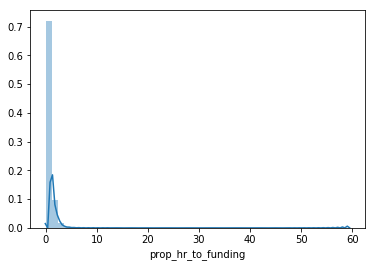

In [6]:
sns.distplot(typical_htf.prop_hr_to_funding)

### Exclude loans with negative time to funding, posted before 2007 and time to funding > 90 days

In [7]:
#Exclude loans posted before 2007 and those that took more than 90 days to fund (except NaNs)
data = data.query('posted_time>=2007 and (hours_to_funding<2161 or hours_to_funding != hours_to_funding)') #90 days = 2160 hours
data[['hours_to_funding', 'status']].head(40)

,hours_to_funding,status
0,711.0,funded
1,301.0,funded
2,153.0,funded
3,NaN,expired
4,281.0,funded
5,485.0,funded
6,NaN,expired
7,198.0,funded
8,115.0,funded
9,595.0,funded


In [8]:
data[['hours_to_funding', 'status', 'prop_hr_to_funding']].head(40)

,hours_to_funding,status,prop_hr_to_funding
0,711.0,funded,0.711000
1,301.0,funded,1.337778
2,153.0,funded,0.211034
3,NaN,expired,NaN
4,281.0,funded,0.281000
5,485.0,funded,0.843478
6,NaN,expired,NaN
7,198.0,funded,0.099000
8,115.0,funded,0.920000
9,595.0,funded,0.820690


In [9]:
data[data.prop_hr_to_funding<0]

,id,name,original_language,original_description,translated_description,funded_amount,loan_amount,status,image_id,video_id,...,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model,time_to_funding,max_time_to_funding,hours_to_funding,max_hours_to_funding,prop_hr_to_funding
879445,1281091,Hortenisa,English,My name is Hortensia and I came to Oakland 29 ...,My name is Hortensia and I came to Oakland 29 ...,2000.0,2000.0,funded,2502198.0,NaN,...,Hortenisa,female,true,monthly,direct,-18 days +11:52:24,10 days 19:36:39,-421.0,259.0,-0.2105


In [10]:
len(data)

1296140

In [12]:
#Eliminate negative funding_time row(s)
data = data.query('prop_hr_to_funding>=0 or prop_hr_to_funding!=prop_hr_to_funding')
len(data)

1296139

In [13]:
data[['hours_to_funding', 'status', 'prop_hr_to_funding']].head(40)

,hours_to_funding,status,prop_hr_to_funding
0,711.0,funded,0.711000
1,301.0,funded,1.337778
2,153.0,funded,0.211034
3,NaN,expired,NaN
4,281.0,funded,0.281000
5,485.0,funded,0.843478
6,NaN,expired,NaN
7,198.0,funded,0.099000
8,115.0,funded,0.920000
9,595.0,funded,0.820690


### Label succesful loans (re-check cutoff point)

In [15]:
pd.DataFrame.describe(data[['prop_hr_to_funding']], percentiles=[0.2, 0.225, 0.25, 0.5, 0.75, 0.8,])

,prop_hr_to_funding
count,1.242661e+06
mean,6.170924e-01
std,8.345410e-01
min,0.000000e+00
20%,1.064706e-01
22.5%,1.223529e-01
25%,1.389474e-01
50%,3.693750e-01
75%,8.059259e-01
80%,9.573333e-01


Cutoff point: prop_hr_to_funding = 0.12

In [22]:
# Create new column to label succesful loans (between 0 and 0.12 prop_hr_to_funding, no NaNs)
data['is_top'] = 1 # Default, to be overwritten below
data.loc[data['prop_hr_to_funding'] > 0.12, 'is_top'] = 0
data.loc[data['prop_hr_to_funding'] < 0, 'is_top'] = 0
data.loc[data['prop_hr_to_funding'] != data['prop_hr_to_funding'], 'is_top'] = 0

In [23]:
len(data[data.is_top==1])/len(data)

0.21368541491306103

In [24]:
len(data[data.prop_hr_to_funding!=data.prop_hr_to_funding])/len(data)

0.04125946368406475

In [25]:
data[['hours_to_funding', 'status', 'prop_hr_to_funding', 'is_top']].head(40)

,hours_to_funding,status,prop_hr_to_funding,is_top
0,711.0,funded,0.711000,0
1,301.0,funded,1.337778,0
2,153.0,funded,0.211034,0
3,NaN,expired,NaN,0
4,281.0,funded,0.281000,0
5,485.0,funded,0.843478,0
6,NaN,expired,NaN,0
7,198.0,funded,0.099000,1
8,115.0,funded,0.920000,0
9,595.0,funded,0.820690,0


In [26]:
data[['original_language', 'original_description', 'translated_description']]

,original_language,original_description,translated_description
0,Spanish,"Norma tiene 38 años de edad, es madre soltera ...",Norma is 38 years old. She is a single mother ...
1,Spanish,sayda es originaria de la comarca Empalme de B...,Sayda is originally from the Empalme de Boaco ...
2,English,Livia is 38 years old and is married to David ...,NaN
3,Spanish,El señor Eduardo de 37 años de edad casado con...,Eduardo is 37 years old. He has been to marrie...
4,English,"Nhanh, age 49, lives in a rural area in the Po...",NaN
5,Spanish,"Rosa, de 42 años, es una mujer amable, solidar...","Rosa, 42 years old, is a nice woman, companion..."
6,English,"Artur lives in Vedi town, Ararat region, with ...",NaN
7,English,Nada is a 45-year-old married woman and mother...,NaN
8,English,"Ines is a 55-year-old woman from Talibon, Boho...",NaN
9,English,Mahmoud is a 44- year-old married man and a fa...,NaN


In [29]:
len(data[data.original_description != data.original_description])

22513

In [31]:
no_desc = data[data.original_description != data.original_description]

In [34]:
pd.DataFrame.describe(no_desc[['prop_hr_to_funding', 'is_top', 'loan_amount']])

,prop_hr_to_funding,is_top,loan_amount
count,22507.000000,22513.000000,22513.000000
mean,0.456987,0.310665,858.080887
std,0.578127,0.462776,1074.886473
min,0.000000,0.000000,25.000000
25%,0.091429,0.000000,350.000000
50%,0.248000,0.000000,600.000000
75%,0.613333,1.000000,1025.000000
max,13.200000,1.000000,49975.000000


In [35]:
pd.DataFrame.describe(data[['prop_hr_to_funding', 'is_top', 'loan_amount']])

,prop_hr_to_funding,is_top,loan_amount
count,1.242661e+06,1.296139e+06,1.296139e+06
mean,6.170924e-01,2.136854e-01,8.336646e+02
std,8.345410e-01,4.099074e-01,1.050179e+03
min,0.000000e+00,0.000000e+00,2.500000e+01
25%,1.389474e-01,0.000000e+00,3.000000e+02
50%,3.693750e-01,0.000000e+00,5.250000e+02
75%,8.059259e-01,0.000000e+00,1.000000e+03
max,5.940000e+01,1.000000e+00,1.000000e+05


## Other things to keep in mind
* Use a fair measure (time/loan_amount) --> prop_time
* Question for the future: __Are loans with a "use" variable better than those without?__

TO DO:
* ~~Label succesful loans (cutoff 0.13)~~
* ~~Eliminate loans with negative time to funding, loans that took more than 90 days and loans posted before January 2007~~
* See if loans without description perform well on average
* Subset the data to do TFIDF